## Importing libraries

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import requests
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

##Setting lines and rows printing configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Getting the stock tickers for all the companies in the S&P500

In [19]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
SP_500_tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    SP_500_tickers.append(ticker)

In [20]:
SP_500_tickers = [s.replace('\n', '') for s in SP_500_tickers]
SP_500_tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'CHRW',
 'CDNS',
 'CZR',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CERN',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMC

**Number of companies listed (inlcluding some delisted ones in the S&P500 Index)**

In [21]:
len(SP_500_tickers)

505

## Getting historical data for the companies in a defined period of time

**Defining period of time for the analysis**

In [22]:
start_time = dt.datetime(2020,1,1)
end_time = dt.datetime(2020,12,31)

**Downloading data**

In [23]:
data = yf.download(SP_500_tickers, start = start_time, end = end_time)

[*********************100%***********************]  505 of 505 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- OGN: Data doesn't exist for startDate = 1577833200, endDate = 1609369200


**Checking for the shape (number of companies & date records) & features of the data**

In [24]:
data.shape

(253, 3030)

**Number of date records -- 253 days are registred (only business days)**

In [25]:
data.index

DatetimeIndex(['2019-12-31', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

**Original features of the data (originally, we have 6 dimensions for each stock)**

In [26]:
list(data.columns.levels[0])

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

**Dropping stocks with missing data**

In [27]:
data.dropna(inplace = True, axis = 1)

In [28]:
data.shape

(253, 3000)

**Getting stocks with all features filled**

In [29]:
valid_stocks = []
number_original_features = len(data.columns.levels[0])
lists_stocks_per_feature = []

for feature in data.columns.levels[0]:
    lists_stocks_per_feature.append(data[feature].columns)

## Getting the intersection of the lists of available stocks per feature
valid_stocks = list(set.intersection(*[set(x) for x in lists_stocks_per_feature]))

In [30]:
len(valid_stocks)

500

**Generating a new feature - DAILY RETURN**

In [31]:
def return_daily_return_as_new_feature(data, valid_stocks):
    for stock in list(valid_stocks):
        data[("Daily Return", stock)] = data[("Adj Close",stock)].pct_change()

In [32]:
return_daily_return_as_new_feature(data, valid_stocks)

**Daily return is a new feature of the data - we have now 7 dimensions**

In [33]:
list(data.columns.levels[0])

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily Return']

In [34]:
list(data["Daily Return"].columns) == valid_stocks

True

**Let's now generate the dimensions that we will use with the PCA reduction method: monthly mean volatility, monthly mean return, monthly mean drawdown, monthly mean traded volume**

<span style="color:red">**Generating a dataframe with monthly returns for all stocks**</span>

In [35]:
def return_monthly_accrued_return_for_each_stock(data, valid_stocks):
    
    monthly_returns = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    daily_returns = data["Daily Return"].iloc[1: , :]
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_stock_monthly_return = 1.0
            current_data = daily_returns[stock][daily_returns.index.month == month]
            number_of_rows = len(current_data)
            for i in range(0, number_of_rows):
                current_stock_monthly_return = current_stock_monthly_return*(1 + current_data.iloc[i])    
            monthly_returns.loc[month][stock] = (current_stock_monthly_return - 1)
            
    return monthly_returns   

In [36]:
monthly_returns = return_monthly_accrued_return_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [37]:
monthly_returns.shape

(12, 500)

**Generating Monthly Mean Return for each stock**

In [38]:
monthly_mean_returns = np.mean(monthly_returns)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Return')

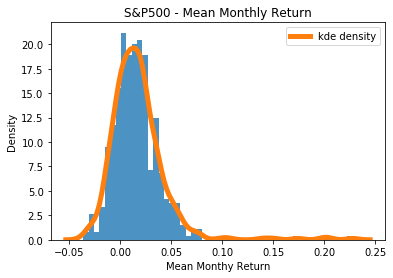

In [39]:
plt.hist(monthly_mean_returns, bins = 50, density = True, alpha = 0.8)
sns.kdeplot(monthly_mean_returns, label = "kde density", linewidth = 5)
plt.xlabel("Mean Monthy Return")
plt.ylabel("Density")
plt.title("S&P500 - Mean Monthly Return")

<span style="color:blue">**Generating a dataframe with monthly traded volume for all stocks**</span>

In [40]:
def return_monthly_total_traded_volume_for_each_stock(data, valid_stocks):
    
    daily_volumes = data["Volume"].dropna(axis = 1)
    monthly_traded_volumes = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_stock_monthly_traded_volume = 0.0
            current_data = daily_volumes[stock][daily_volumes.index.month == month]
            number_of_rows = len(current_data)
            for i in range(0, number_of_rows):
                current_stock_monthly_traded_volume = current_stock_monthly_traded_volume + current_data.iloc[i]    
            monthly_traded_volumes.loc[month][stock] = current_stock_monthly_traded_volume
            
    return monthly_traded_volumes  

In [41]:
monthly_traded_volumes = return_monthly_total_traded_volume_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [42]:
monthly_traded_volumes.shape

(12, 500)

**Generating Monthly Mean Traded Volume for each stock**

In [43]:
monthly_mean_traded_volumes = np.mean(monthly_traded_volumes)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Traded Volume')

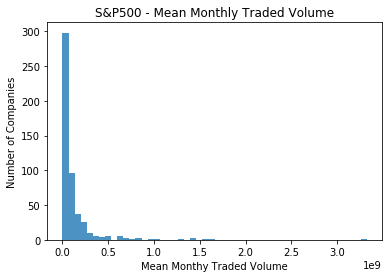

In [44]:
plt.hist(monthly_mean_traded_volumes, bins = 50, alpha = 0.8)
plt.xlabel("Mean Monthy Traded Volume")
plt.ylabel("Number of Companies")
plt.title("S&P500 - Mean Monthly Traded Volume")

<span style="color:blue">**Generating a dataframe with monthly volatility for each stock**</span>

In [45]:
def return_monthly_volatility_for_each_stock(data, valid_stocks):
    
    daily_returns = data["Daily Return"].iloc[1: , :]
    monthly_volatiities = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_data = daily_returns[stock][daily_returns.index.month == month]   
            monthly_volatiities.loc[month][stock] = current_data.std()
            
    return monthly_volatiities

In [46]:
monthly_volatiities = return_monthly_volatility_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [47]:
monthly_volatiities.shape

(12, 500)

**Generating Monthly Mean Volatility for each stock**

In [48]:
monthly_mean_volatility = np.mean(monthly_volatiities)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Volatility')

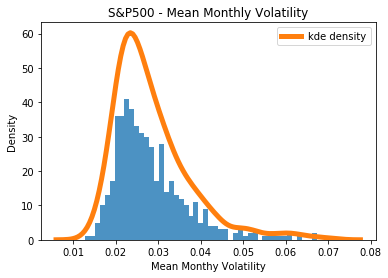

In [49]:
plt.hist(monthly_mean_volatility, bins = 50, alpha = 0.8)
sns.kdeplot(monthly_mean_volatility, label = "kde density", linewidth = 5)
plt.xlabel("Mean Monthy Volatility")
plt.ylabel("Density")
plt.title("S&P500 - Mean Monthly Volatility")

<span style="color:blue">**Generating a dataframe with maximum monthly drawdown for each stock**</span>

In [50]:
def return_monthly_maximum_drawdown_for_each_stock(data, valid_stocks):
    
    adjusted_close_prices = data["Adj Close"]
    monthly_drawdowns = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_data = adjusted_close_prices[stock][adjusted_close_prices.index.month == month]
            current_data_max = current_data.max()
            current_data_min = current_data.min()
            monthly_drawdowns.loc[month][stock] = current_data_max - current_data_min
            
    return monthly_drawdowns

In [51]:
monthly_drawdowns = return_monthly_maximum_drawdown_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [52]:
monthly_drawdowns.shape

(12, 500)

**Generating Monthly Mean Maximum Drawdown for each stock**

In [53]:
monthly_mean_drawdown = np.mean(monthly_drawdowns)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Maximum Drawdown')

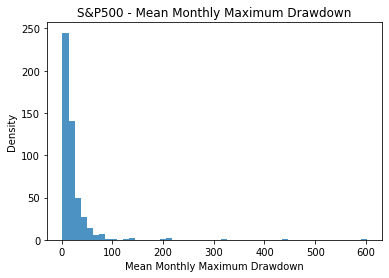

In [54]:
plt.hist(monthly_mean_drawdown, bins = 50, alpha = 0.8)
plt.xlabel("Mean Monthly Maximum Drawdown")
plt.ylabel("Density")
plt.title("S&P500 - Mean Monthly Maximum Drawdown")

**Generating a DataFrame with the final features**

In [55]:
final_features = pd.DataFrame({ 'Mean Monthly Return': monthly_mean_returns, 'Mean Monthly Traded Volume': monthly_mean_traded_volumes, 'Mean Monthly Volatility': monthly_mean_volatility, 'Mean Monthly Maximum Drawdown': monthly_mean_drawdown})


In [56]:
final_features.shape

(500, 4)

In [57]:
final_features.head()

,Mean Monthly Return,Mean Monthly Traded Volume,Mean Monthly Volatility,Mean Monthly Maximum Drawdown
IPG,0.011576,9.545702e+07,0.031499,3.244268
V,0.016937,2.051184e+08,0.022153,26.016464
HWM,0.016690,8.068492e+07,0.042575,5.074068
MRO,0.008212,6.634192e+08,0.050598,2.611442
ABT,0.022444,1.413609e+08,0.020818,11.705959


## Standardizing Data for PCA Algorithm - Can we identify industry sector with these features ?

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
final_features = pd.DataFrame(scaler.fit_transform(final_features), columns = final_features.columns, index = final_features.index)

In [59]:
final_features.head()

,Mean Monthly Return,Mean Monthly Traded Volume,Mean Monthly Volatility,Mean Monthly Maximum Drawdown
IPG,-0.208246,-0.104311,0.334293,-0.467842
V,-0.014387,0.345945,-0.692129,0.075559
HWM,-0.023326,-0.164964,1.550930,-0.424179
MRO,-0.329918,2.227672,2.432132,-0.482943
ABT,0.184784,0.084164,-0.838766,-0.265925


**Getting companies' industry sector, dividends, number of employees, profit margins and market capitalization for enhancing classification analyses of PCA's performance**

<span style="color:red">**Attention! This cell takes about half hour to execute.**</span>

In [60]:
valid_stock_sectors = []
valid_stock_dividends = []
valid_stock_employees = []
valid_stocks_profit_margins = []
valid_stocks_market_cap = []

 
for stock in valid_stocks:
    flag = 1
    tickerdata = yf.Ticker(stock)
    try:
        valid_stock_sectors.append(tickerdata.info['sector'])
    except:
        flag = 0
        print(f"Sector not found for {stock}.\n")
        valid_stock_sectors.append("null")
    try:
        valid_stock_dividends.append(tickerdata.info['dividendRate'])
    except:
        flag = 0
        print(f"Dividends rate not found for {stock}.\n")
        valid_stock_dividends.append(np.mean(valid_stock_dividends))
    try:
        valid_stock_employees.append(tickerdata.info['fullTimeEmployees'])
    except:
        flag = 0
        print(f"Number of employees not found for {stock}.\n")
        valid_stock_employees.append(int(np.mean(valid_stock_employees)))   
    try:
        valid_stocks_profit_margins.append(tickerdata.info['profitMargins'])
    except:
        flag = 0
        print(f"Profit margins not found for {stock}.\n")
        valid_stocks_profit_margins.append(np.mean(valid_stocks_profit_margins)) 
    try:
        valid_stocks_market_cap.append(tickerdata.info['marketCap'])
    except:
        flag = 0
        print(f"Market capitalization not found for {stock}.\n")
        valid_stocks_market_cap.append(np.mean(valid_stocks_market_cap))
    if(flag == 1):
        print(f'Complete data found for company with ticker: {stock}\n')

Complete data found for company with ticker: IPG

Complete data found for company with ticker: V

Complete data found for company with ticker: HWM

Complete data found for company with ticker: MRO

Complete data found for company with ticker: ABT

Complete data found for company with ticker: DAL

Complete data found for company with ticker: CSCO

Complete data found for company with ticker: OXY

Complete data found for company with ticker: ULTA

Complete data found for company with ticker: TECH

Complete data found for company with ticker: PRU

Complete data found for company with ticker: VTRS

Complete data found for company with ticker: PKI

Complete data found for company with ticker: EMN

Complete data found for company with ticker: TFC

Complete data found for company with ticker: CDNS

Complete data found for company with ticker: HSY

Complete data found for company with ticker: CMI

Complete data found for company with ticker: ILMN

Complete data found for company with ticker: C

Complete data found for company with ticker: DVN

Complete data found for company with ticker: SNPS

Complete data found for company with ticker: TMUS

Complete data found for company with ticker: SBAC

Complete data found for company with ticker: YUM

Complete data found for company with ticker: CTVA

Complete data found for company with ticker: PNW

Complete data found for company with ticker: SCHW

Complete data found for company with ticker: COP

Complete data found for company with ticker: LMT

Complete data found for company with ticker: GILD

Complete data found for company with ticker: NLOK

Complete data found for company with ticker: XLNX

Complete data found for company with ticker: PEAK

Complete data found for company with ticker: NEM

Complete data found for company with ticker: CSX

Complete data found for company with ticker: GPS

Complete data found for company with ticker: ROL

Complete data found for company with ticker: RSG

Complete data found for company with tick

Complete data found for company with ticker: SHW

Number of employees not found for MET.

Complete data found for company with ticker: SWKS

Complete data found for company with ticker: VIAC

Complete data found for company with ticker: AVGO

Complete data found for company with ticker: DLR

Complete data found for company with ticker: GNRC

Complete data found for company with ticker: CCL

Complete data found for company with ticker: NUE

Complete data found for company with ticker: ALB

Complete data found for company with ticker: SWK

Complete data found for company with ticker: NKE

Complete data found for company with ticker: DTE

Complete data found for company with ticker: FISV

Complete data found for company with ticker: MS

Complete data found for company with ticker: BDX

Complete data found for company with ticker: CNP

Complete data found for company with ticker: JNPR

Complete data found for company with ticker: ETR

Complete data found for company with ticker: BWA

Compl

Complete data found for company with ticker: NWL

Complete data found for company with ticker: STX

Complete data found for company with ticker: TT

Complete data found for company with ticker: VRSK

Complete data found for company with ticker: BIO

Complete data found for company with ticker: DHR

Complete data found for company with ticker: ROST

Complete data found for company with ticker: FTNT



**Replace "null" sectors with the most present sector**

In [61]:
from collections import Counter
c = Counter(valid_stock_sectors)
most_frequent_sector = c.most_common(1)[0][0]
print(f"The most frequent sector is: {most_frequent_sector}.\n")

i = 0
for i in range(len(valid_stock_sectors)):
    if(valid_stock_sectors[i] == "null"):
        valid_stock_sectors[i] = most_frequent_sector    

The most frequent sector is: Technology.



In [62]:
i = 0
for i in range(len(valid_stock_dividends)):
    if(valid_stock_dividends[i] == None):
        valid_stock_dividends[i] = 0.0
    if(valid_stocks_market_cap[i] == None):
        valid_stocks_market_cap[i] = 0.0

<span style="color:blue">**Sector Analyses before PCA results**</span>

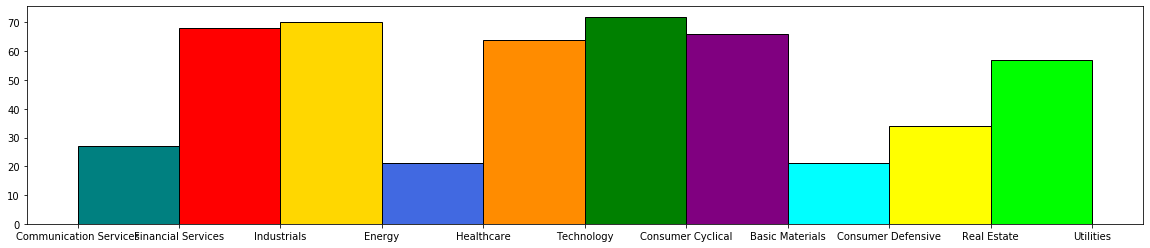

In [63]:
colors = ['teal', 'red', 'gold', 'royalblue', 'darkorange', 'green', 'purple', 'cyan', 'yellow', 'lime', 'sienna']

fig, ax = plt.subplots(figsize=(20,4), facecolor='w')
cnts, values, bars = ax.hist(valid_stock_sectors, edgecolor='k')

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(colors[i % len(colors)])

**Assigning a color to each sector**

In [64]:
available_sectors = list(set(valid_stock_sectors))
valid_stock_sectors_colors = []

for stock_sector in valid_stock_sectors:
    valid_stock_sectors_colors.append(colors[available_sectors.index(stock_sector)])

## Running PCA Algorithm - with only the first 4 generated features (monthly mean return, traded volume, volatility and maximum drawdown)

In [65]:
from sklearn.decomposition import PCA

In [66]:
pca_model_I = PCA(n_components = 4)

In [67]:
pca_results_I = pca_model_I.fit_transform(final_features)

Text(0.5, 1.0, 'PCA Results - Scattering')

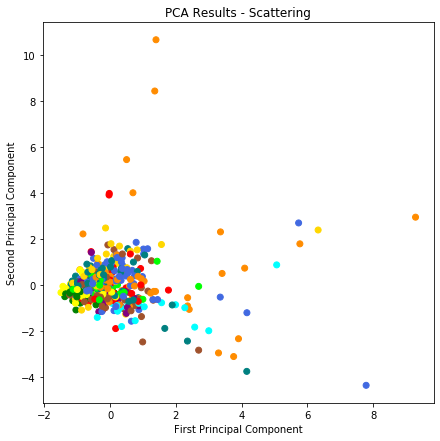

In [68]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
plt.scatter(pca_results_I[:,0], pca_results_I[:,1], c = valid_stock_sectors_colors)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Results - Scattering")

In [70]:
print(available_sectors)  
print("\n")
print(colors)

['Industrials', 'Communication Services', 'Healthcare', 'Technology', 'Consumer Cyclical', 'Utilities', 'Real Estate', 'Energy', 'Consumer Defensive', 'Basic Materials', 'Financial Services']


['teal', 'red', 'gold', 'royalblue', 'darkorange', 'green', 'purple', 'cyan', 'yellow', 'lime', 'sienna']


**What is the explained variance ratio by the principal components ?**

In [71]:
pca_model_I.explained_variance_ratio_

array([0.34516776, 0.29072743, 0.19334438, 0.17076043])

## Can we enhance the industry sector clustering with more features (dividends, number of employees, market capitalization and profit margins) ?

**Standardazing new data**

In [72]:
valid_stock_dividends = valid_stock_dividends - np.mean(valid_stock_dividends)
valid_stock_employees = valid_stock_employees - np.mean(valid_stock_employees)
valid_stocks_market_cap = valid_stocks_market_cap - np.mean(valid_stocks_market_cap) 
valid_stocks_profit_margins = valid_stocks_profit_margins  - np.mean(valid_stocks_profit_margins )

In [73]:
valid_stock_dividends = valid_stock_dividends/np.std(valid_stock_dividends)
valid_stock_employees  = valid_stock_employees /np.std(valid_stock_employees)
valid_stocks_market_cap = valid_stocks_market_cap/np.std(valid_stocks_market_cap)
valid_stocks_profit_margins  = valid_stocks_profit_margins/np.std(valid_stocks_profit_margins)

In [74]:
final_features['Dividends'] = valid_stock_dividends
final_features['Employess'] = valid_stock_employees
final_features['Mkt Cap'] = valid_stocks_market_cap
final_features['Profit Margins'] = valid_stocks_profit_margins

**Trying different combinations of features**

**Combination I - 'Mkt Cap', 'Profit Margins'**

In [75]:
final_features_match_I = final_features[['Mkt Cap', 'Profit Margins']]

In [76]:
pca_model_match_I = PCA(n_components = 2)

In [77]:
pca_results_match_I = pca_model_match_I.fit_transform(final_features_match_I)

Text(0.5, 1.0, 'PCA Results - Combination I - Scattering')

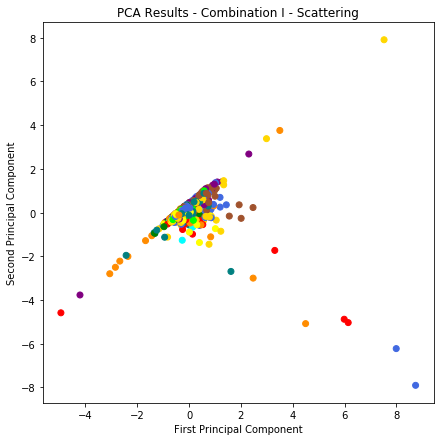

In [85]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
plt.scatter(pca_results_match_I[:,0], pca_results_match_I[:,1], c = valid_stock_sectors_colors)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Results - Combination I - Scattering")

In [86]:
pca_model_match_I.explained_variance_ratio_

array([0.55070363, 0.44929637])

**Combination II**

In [109]:
final_features_match_II = final_features[['Profit Margins', 'Mean Monthly Return']]

In [110]:
pca_model_match_II = PCA(n_components = 2)

In [111]:
pca_results_match_II = pca_model_match_II.fit_transform(final_features_match_II)

Text(0.5, 1.0, 'PCA Results - Combination II - Scattering')

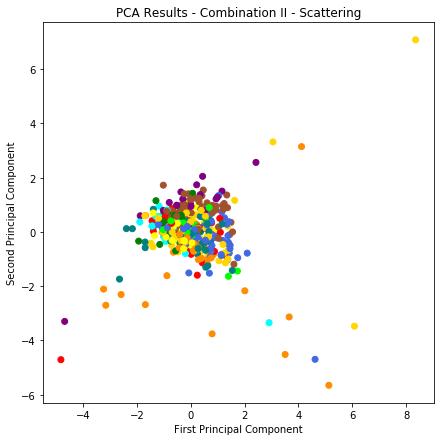

In [112]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
plt.scatter(pca_results_match_II[:,0], pca_results_match_II[:,1], c = valid_stock_sectors_colors)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Results - Combination II - Scattering")

In [113]:
pca_model_match_II.explained_variance_ratio_

array([0.56052994, 0.43947006])

## Trying PCA with all features

In [138]:
pca_model_final = PCA(n_components = 8)

In [139]:
pca_model_final = pca_model_final.fit(final_features)

**Explained variance by feature**

In [144]:
pca_model_final.explained_variance_ratio_

array([0.22919504, 0.19636562, 0.15142457, 0.12799685, 0.09504479,
       0.0878356 , 0.07448271, 0.03765481])

In [141]:
cumulative_sum_explained_variance = np.cumsum(pca_model_final.explained_variance_ratio_)

Text(0.5, 1.0, 'PCA Results with all features  - Total Cumulative Explained Variance')

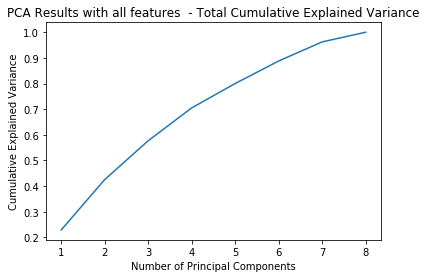

In [142]:
plt.plot(np.arange(1,9),cumulative_sum_explained_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Results with all features  - Total Cumulative Explained Variance")

**Plotting data with the first two components**

In [145]:
pca_final_components = pca_model_final.transform(final_features) 

Text(0.5, 1.0, 'PCA Results - All Features - Scattering')

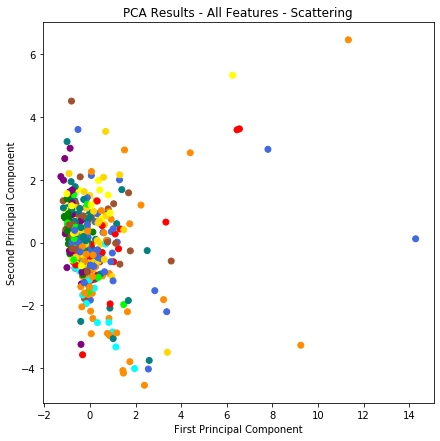

In [146]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
plt.scatter(pca_final_components[:,0], pca_final_components[:,1], c = valid_stock_sectors_colors)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Results - All Features - Scattering")